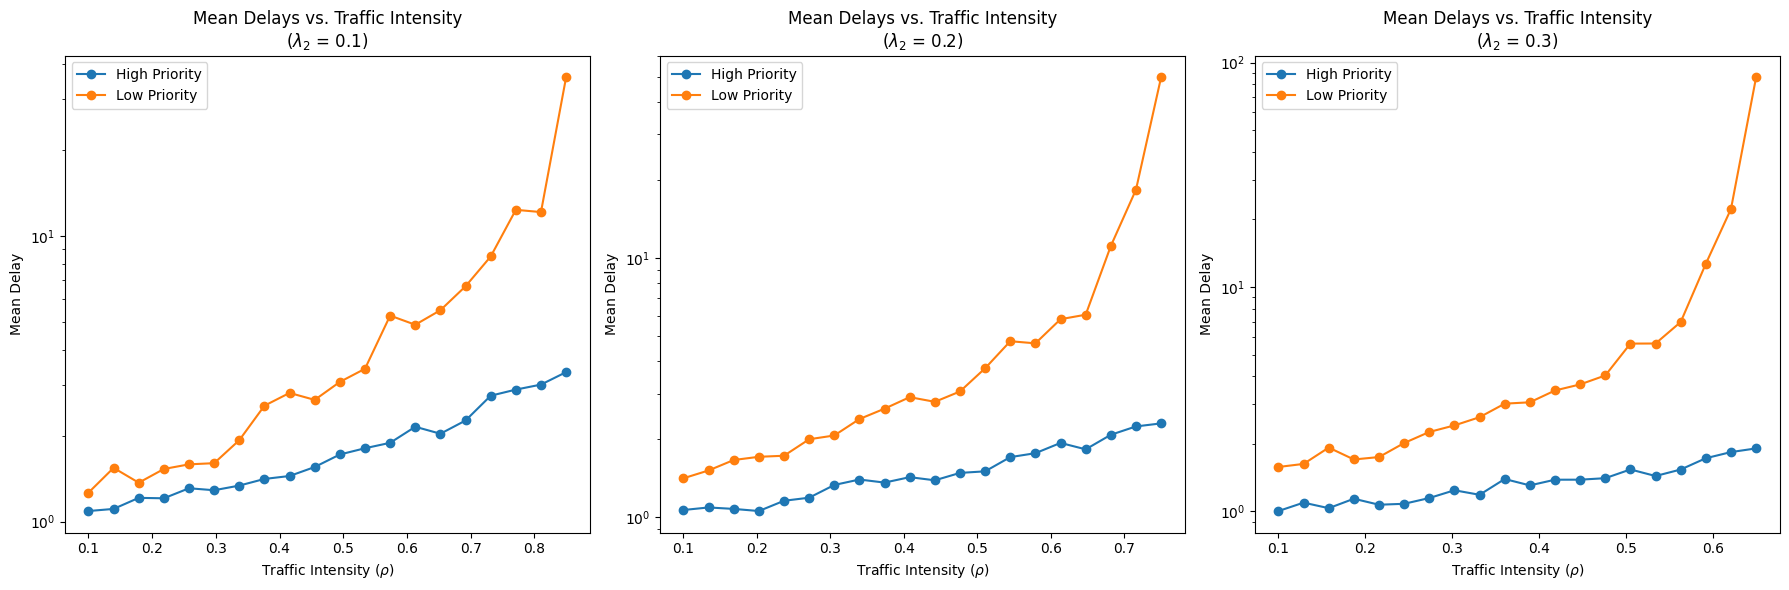

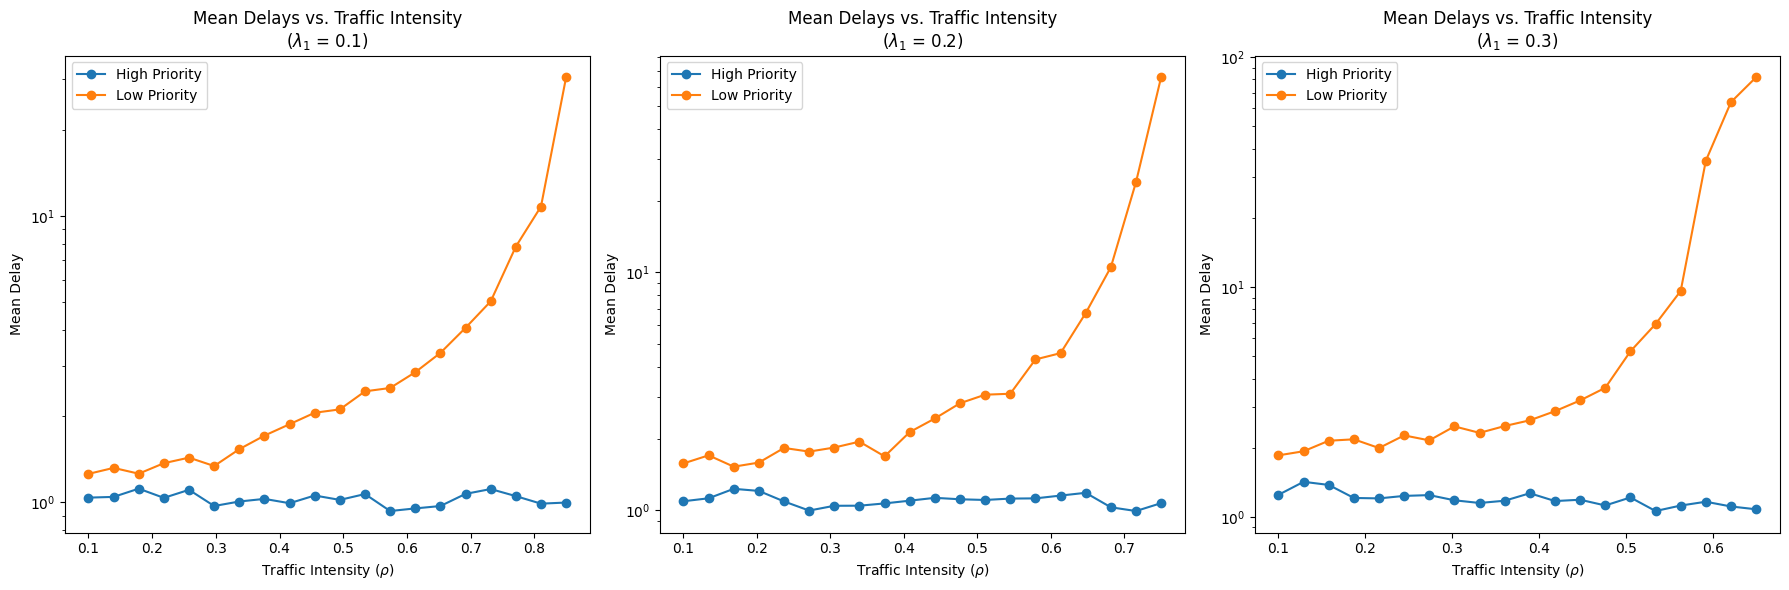

In [1]:
import heapq
import random
import matplotlib.pyplot as plt
import numpy as np
random.seed(123456)

def simulate_preemptive(a_rate1, a_rate2, s_rate, warmup_customers=800):
    mean_delay1 = []
    mean_delay2 = []
    means_cust = []

    for i in range(200):  # Run 200 trials
        clock = 0
        next_arrival1 = random.expovariate(a_rate1)
        next_arrival2 = random.expovariate(a_rate2)
        next_departure = float('inf')
        queue1 = []  # High priority queue
        queue2 = []  # Low priority queue
        total_delay1 = 0
        total_delay2 = 0
        total_customers1 = 0
        total_customers2 = 0
        customers1_post_warmup = 0
        customers2_post_warmup = 0
        queue_snapshot = []
        serving_low_priority = False
        remaining_service_time = None

        while total_customers1 + total_customers2 < 6000:  # Simulate until 3000 customers have been served
            next_event_time = min(next_arrival1, next_arrival2, next_departure)
            
            if next_event_time == next_arrival1:
                clock = next_arrival1
                total_customers1 += 1
                heapq.heappush(queue1, clock)
                next_arrival1 = clock + random.expovariate(a_rate1)
                if serving_low_priority:
                    remaining_service_time = next_departure - clock
                    next_departure = clock + remaining_service_time
                    serving_low_priority = False
            elif next_event_time == next_arrival2:
                clock = next_arrival2
                total_customers2 += 1
                heapq.heappush(queue2, clock)
                next_arrival2 = clock + random.expovariate(a_rate2)

            if len(queue1) + len(queue2) == 1 and next_departure == float('inf'):
                service_time = random.expovariate(s_rate)
                next_departure = clock + service_time

            if next_event_time == next_departure:
                clock = next_departure
                if queue1:
                    fifo_time = heapq.heappop(queue1)
                    total_delay1 += clock - fifo_time
                    customers1_post_warmup += 1
                    service_time = random.expovariate(s_rate)
                    next_departure = clock + service_time
                    serving_low_priority = False
                elif queue2:
                    if remaining_service_time is not None:
                        next_departure = clock + remaining_service_time
                        remaining_service_time = None
                    else:
                        fifo_time = heapq.heappop(queue2)
                        total_delay2 += clock - fifo_time
                        customers2_post_warmup += 1
                        service_time = random.expovariate(s_rate)
                        next_departure = clock + service_time
                        serving_low_priority = True

            if len(queue1) + len(queue2) == 0:
                clock = min(next_arrival1, next_arrival2)
                next_departure = float('inf')

            if total_customers1 + total_customers2 > warmup_customers:  # Collect data only after warm-up period
                queue_snapshot.append(len(queue1) + len(queue2))

        mean_delay1.append(total_delay1 / max(1, customers1_post_warmup))
        mean_delay2.append(total_delay2 / max(1, customers2_post_warmup))
        means_cust.append(np.mean(queue_snapshot))

    return mean_delay1, mean_delay2, means_cust


def plot_mean_delays_vs_rho(fixed_rates, s_rate, varying_rate='a_rate1'):
    plt.figure(figsize=(18, 6))

    for i, fixed_rate in enumerate(fixed_rates):
        rho_values = []
        mean_delays1 = []
        mean_delays2 = []

        if varying_rate == 'a_rate1':
            a_rate2 = fixed_rate
            a_rate1_values = np.linspace(0.1, 1 - a_rate2 - 0.05, 20)
            for a_rate1 in a_rate1_values:
                rho_values.append(a_rate1 / s_rate)
                mean_delay1, mean_delay2, _ = simulate_preemptive(a_rate1, a_rate2, s_rate)
                mean_delays1.append(np.mean(mean_delay1))
                mean_delays2.append(np.mean(mean_delay2))
        else:
            a_rate1 = fixed_rate
            a_rate2_values = np.linspace(0.1, 1 - a_rate1 - 0.05, 20)
            for a_rate2 in a_rate2_values:
                rho_values.append(a_rate2 / s_rate)
                mean_delay1, mean_delay2, _ = simulate_preemptive(a_rate1, a_rate2, s_rate)
                mean_delays1.append(np.mean(mean_delay1))
                mean_delays2.append(np.mean(mean_delay2))

        plt.subplot(1, 3, i + 1)
        plt.plot(rho_values, mean_delays1, label='High Priority', marker='o')
        plt.plot(rho_values, mean_delays2, label='Low Priority', marker='o')
        plt.xlabel(r'Traffic Intensity ($\rho$)')
        plt.ylabel('Mean Delay')
        plt.yscale('log')
        if varying_rate == 'a_rate1':
            plt.title(f'Mean Delays vs. Traffic Intensity\n($\lambda_2$ = {fixed_rate})')
        else:
            plt.title(f'Mean Delays vs. Traffic Intensity\n($\lambda_1$ = {fixed_rate})')
        plt.legend()

    plt.tight_layout()
    plt.show()


fixed_rates = [0.1, 0.2, 0.3]
s_rate = 1
plot_mean_delays_vs_rho(fixed_rates, s_rate, varying_rate='a_rate1')  # Varying a_rate1
plot_mean_delays_vs_rho(fixed_rates, s_rate, varying_rate='a_rate2')  # Varying a_rate2

In [2]:

def simulate_priority(a_rate1, a_rate2, s_rate, warmup_customers=800):
    mean_delay1 = []
    mean_delay2 = []
    means_cust = []

    for i in range(200):  # Run 200 trials
        clock = 0
        next_arrival1 = random.expovariate(a_rate1)
        next_arrival2 = random.expovariate(a_rate2)
        next_departure = float('inf')
        queue1 = []  # High priority queue
        queue2 = []  # Low priority queue
        total_delay1 = 0
        total_delay2 = 0
        total_customers1 = 0
        total_customers2 = 0
        customers1_post_warmup = 0
        customers2_post_warmup = 0
        queue_snapshot = []
        current_serving = None  # Can be 'high' or 'low' depending on the priority being served

        while total_customers1 + total_customers2 < 6000:  # Simulate until 6000 customers have been served
            next_event_time = min(next_arrival1, next_arrival2, next_departure)
            
            if next_event_time == next_arrival1:
                clock = next_arrival1
                total_customers1 += 1
                heapq.heappush(queue1, clock)
                next_arrival1 = clock + random.expovariate(a_rate1)
                
            elif next_event_time == next_arrival2:
                clock = next_arrival2
                total_customers2 += 1
                heapq.heappush(queue2, clock)
                next_arrival2 = clock + random.expovariate(a_rate2)

            if len(queue1) + len(queue2) == 1 and next_departure == float('inf'):
                service_time = random.expovariate(s_rate)
                next_departure = clock + service_time
                current_serving = 'high' if queue1 else 'low'

            if next_event_time == next_departure:
                clock = next_departure
                if queue1 and (current_serving == 'high' or not queue2):
                    fifo_time = heapq.heappop(queue1)
                    total_delay1 += clock - fifo_time
                    customers1_post_warmup += 1
                    current_serving = 'high'
                elif queue2 and current_serving == 'low':
                    fifo_time = heapq.heappop(queue2)
                    total_delay2 += clock - fifo_time
                    customers2_post_warmup += 1
                    current_serving = 'low'

                if queue1 or queue2:
                    service_time = random.expovariate(s_rate)
                    next_departure = clock + service_time
                    current_serving = 'high' if queue1 else 'low'
                else:
                    next_departure = float('inf')

            if total_customers1 + total_customers2 > warmup_customers:  # Collect data only after warm-up period
                queue_snapshot.append(len(queue1) + len(queue2))

        mean_delay1.append(total_delay1 / max(1, customers1_post_warmup))
        mean_delay2.append(total_delay2 / max(1, customers2_post_warmup))
        means_cust.append(np.mean(queue_snapshot))

    return mean_delay1, mean_delay2, means_cust

# def plot_mean_delays_vs_rho(fixed_rates, s_rate, varying_rate='a_rate1'):
#     plt.figure(figsize=(18, 6))

#     for i, fixed_rate in enumerate(fixed_rates):
#         rho_values = []
#         mean_delays1 = []
#         mean_delays2 = []

#         if varying_rate == 'a_rate1':
#             a_rate2 = fixed_rate
#             a_rate1_values = np.linspace(0.1, 1 - a_rate2 - 0.05, 20)
#             for a_rate1 in a_rate1_values:
#                 rho_values.append(a_rate1 / s_rate)
#                 mean_delay1, mean_delay2, _ = simulate_priority(a_rate1, a_rate2, s_rate)
#                 mean_delays1.append(np.mean(mean_delay1))
#                 mean_delays2.append(np.mean(mean_delay2))
#         else:
#             a_rate1 = fixed_rate
#             a_rate2_values = np.linspace(0.1, 1 - a_rate1 - 0.05, 20)
#             for a_rate2 in a_rate2_values:
#                 rho_values.append(a_rate2 / s_rate)
#                 mean_delay1, mean_delay2, _ = simulate_priority(a_rate1, a_rate2, s_rate)
#                 mean_delays1.append(np.mean(mean_delay1))
#                 mean_delays2.append(np.mean(mean_delay2))

#         plt.subplot(1, 3, i + 1)
#         plt.plot(rho_values, mean_delays1, label='High Priority', marker='o')
#         plt.plot(rho_values, mean_delays2, label='Low Priority', marker='o')
#         plt.xlabel(r'Traffic Intensity ($\rho$)')
#         plt.ylabel('Mean Delay')
#         plt.yscale('log')
#         if varying_rate == 'a_rate1':
#             plt.title(f'Mean Delays vs. Traffic Intensity\n($\lambda_2$ = {fixed_rate})')
#         else:
#             plt.title(f'Mean Delays vs. Traffic Intensity\n($\lambda_1$ = {fixed_rate})')
#         plt.legend()

#     plt.tight_layout()
#     plt.show()


# fixed_rates = [0.1, 0.2, 0.3]
# s_rate = 1
# plot_mean_delays_vs_rho(fixed_rates, s_rate, varying_rate='a_rate1')  # Varying a_rate1
# plot_mean_delays_vs_rho(fixed_rates, s_rate, varying_rate='a_rate2')  # Varying a_rate2


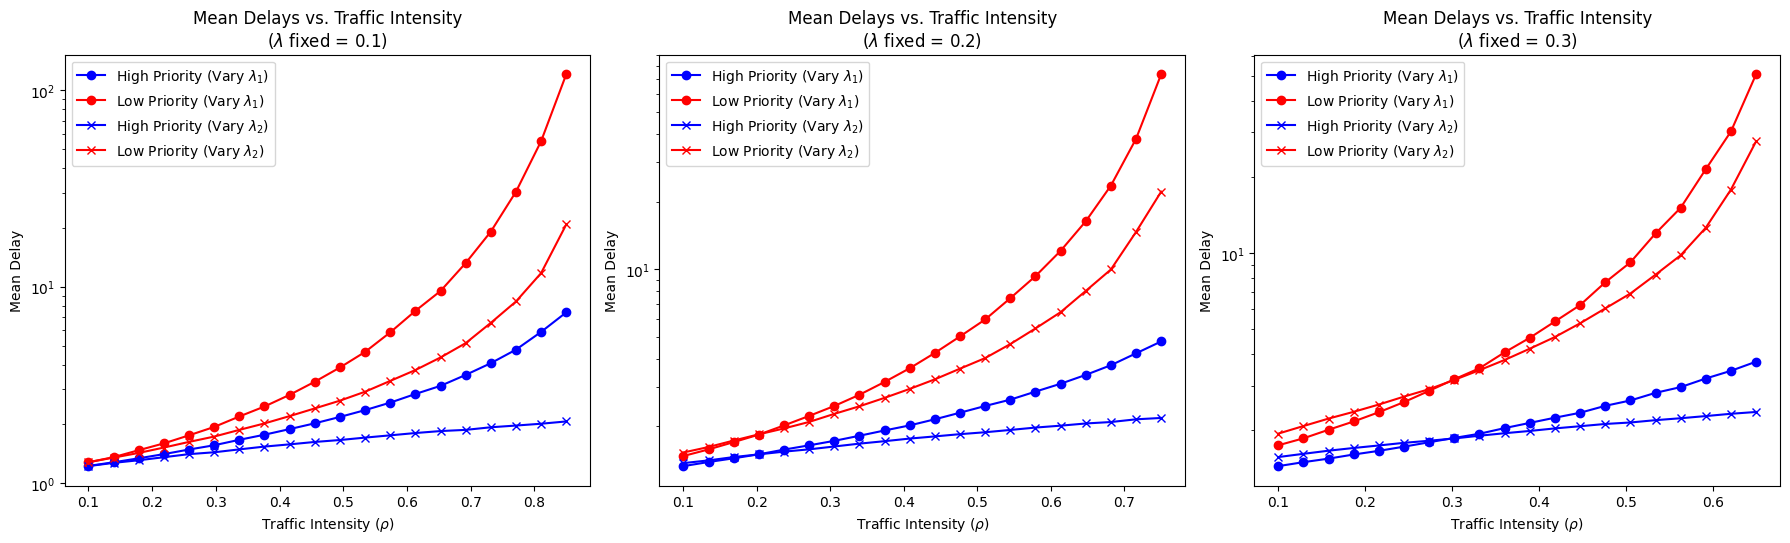

In [3]:
def plot_mean_delays_vs_rho_combined(fixed_rates, s_rate):
    plt.figure(figsize=(18, 10))

    for i, fixed_rate in enumerate(fixed_rates):
        # Vary a_rate1 with a_rate2 fixed
        rho_values1 = []
        mean_delays1_high = []
        mean_delays1_low = []
        
        a_rate2 = fixed_rate
        a_rate1_values = np.linspace(0.1, 1 - a_rate2 - 0.05, 20)
        for a_rate1 in a_rate1_values:
            rho_values1.append(a_rate1 / s_rate)
            mean_delay1_high, mean_delay1_low, _ = simulate_priority(a_rate1, a_rate2, s_rate)
            mean_delays1_high.append(np.mean(mean_delay1_high))
            mean_delays1_low.append(np.mean(mean_delay1_low))
        
        # Vary a_rate2 with a_rate1 fixed
        rho_values2 = []
        mean_delays2_high = []
        mean_delays2_low = []
        
        a_rate1 = fixed_rate
        a_rate2_values = np.linspace(0.1, 1 - a_rate1 - 0.05, 20)
        for a_rate2 in a_rate2_values:
            rho_values2.append(a_rate2 / s_rate)
            mean_delay2_high, mean_delay2_low, _ = simulate_priority(a_rate1, a_rate2, s_rate)
            mean_delays2_high.append(np.mean(mean_delay2_high))
            mean_delays2_low.append(np.mean(mean_delay2_low))
        
        plt.subplot(2, 3, i + 1)
        plt.plot(rho_values1, mean_delays1_high, label='High Priority (Vary $\lambda_1$)', marker='o', color='blue')
        plt.plot(rho_values1, mean_delays1_low, label='Low Priority (Vary $\lambda_1$)', marker='o', color='red')
        plt.plot(rho_values2, mean_delays2_high, label='High Priority (Vary $\lambda_2$)', marker='x', color='blue')
        plt.plot(rho_values2, mean_delays2_low, label='Low Priority (Vary $\lambda_2$)', marker='x', color='red')
        plt.xlabel(r'Traffic Intensity ($\rho$)')
        plt.ylabel('Mean Delay')
        plt.yscale('log')
        plt.title(f'Mean Delays vs. Traffic Intensity\n($\lambda$ fixed = {fixed_rate})')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Define fixed rates and service rate
fixed_rates = [0.1, 0.2, 0.3]
s_rate = 1
plot_mean_delays_vs_rho_combined(fixed_rates, s_rate)


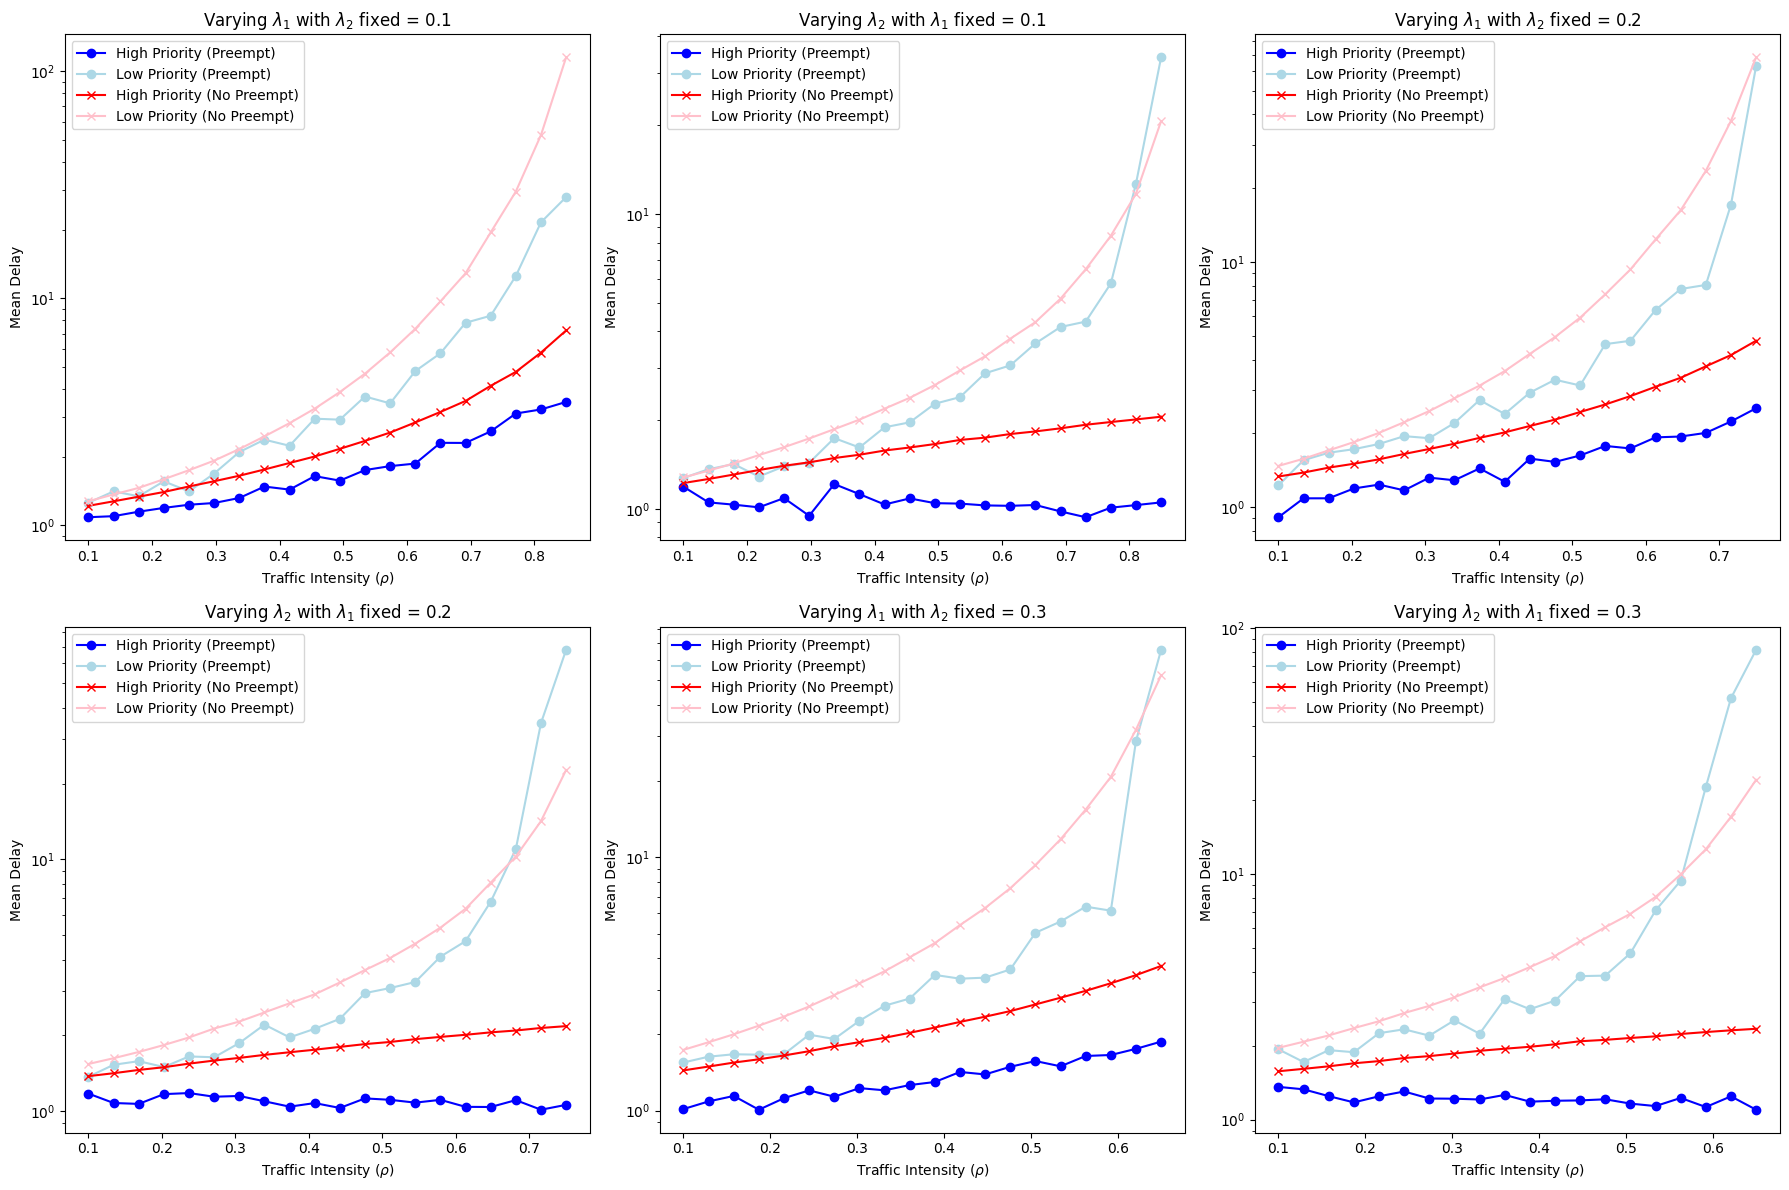

In [4]:
def plot_comparison_all_cases(fixed_rates, s_rate):
    plt.figure(figsize=(18, 12))

    for i, fixed_rate in enumerate(fixed_rates):
        # Prepare data for varying a_rate1 with a_rate2 fixed
        a_rate2 = fixed_rate
        a_rate1_values = np.linspace(0.1, 1 - a_rate2 - 0.05, 20)
        rho_values1 = [a_rate1 / s_rate for a_rate1 in a_rate1_values]
        
        # Preempt/Resume and Priority without Preemption for varying a_rate1
        preempt_high1, preempt_low1, priority_high1, priority_low1 = [], [], [], []
        for a_rate1 in a_rate1_values:
            mean_delay1_high, mean_delay1_low, _ = simulate_preemptive(a_rate1, a_rate2, s_rate)
            preempt_high1.append(np.mean(mean_delay1_high))
            preempt_low1.append(np.mean(mean_delay1_low))
            mean_delay1_high, mean_delay1_low, _ = simulate_priority(a_rate1, a_rate2, s_rate)
            priority_high1.append(np.mean(mean_delay1_high))
            priority_low1.append(np.mean(mean_delay1_low))
        
        # Prepare data for varying a_rate2 with a_rate1 fixed
        a_rate1 = fixed_rate
        a_rate2_values = np.linspace(0.1, 1 - a_rate1 - 0.05, 20)
        rho_values2 = [a_rate2 / s_rate for a_rate2 in a_rate2_values]
        
        # Preempt/Resume and Priority without Preemption for varying a_rate2
        preempt_high2, preempt_low2, priority_high2, priority_low2 = [], [], [], []
        for a_rate2 in a_rate2_values:
            mean_delay2_high, mean_delay2_low, _ = simulate_preemptive(a_rate1, a_rate2, s_rate)
            preempt_high2.append(np.mean(mean_delay2_high))
            preempt_low2.append(np.mean(mean_delay2_low))
            mean_delay2_high, mean_delay2_low, _ = simulate_priority(a_rate1, a_rate2, s_rate)
            priority_high2.append(np.mean(mean_delay2_high))
            priority_low2.append(np.mean(mean_delay2_low))

        # Plot results for varying a_rate1
        plt.subplot(2, 3, 2 * i + 1)
        plt.plot(rho_values1, preempt_high1, label='High Priority (Preempt)', marker='o', color='blue')
        plt.plot(rho_values1, preempt_low1, label='Low Priority (Preempt)', marker='o', color='lightblue')
        plt.plot(rho_values1, priority_high1, label='High Priority (No Preempt)', marker='x', color='red')
        plt.plot(rho_values1, priority_low1, label='Low Priority (No Preempt)', marker='x', color='pink')
        plt.xlabel(r'Traffic Intensity ($\rho$)')
        plt.ylabel('Mean Delay')
        plt.yscale('log')
        plt.title(f'Varying $\lambda_1$ with $\lambda_2$ fixed = {fixed_rate}')
        plt.legend()

        # Plot results for varying a_rate2
        plt.subplot(2, 3, 2 * i + 2)
        plt.plot(rho_values2, preempt_high2, label='High Priority (Preempt)', marker='o', color='blue')
        plt.plot(rho_values2, preempt_low2, label='Low Priority (Preempt)', marker='o', color='lightblue')
        plt.plot(rho_values2, priority_high2, label='High Priority (No Preempt)', marker='x', color='red')
        plt.plot(rho_values2, priority_low2, label='Low Priority (No Preempt)', marker='x', color='pink')
        plt.xlabel(r'Traffic Intensity ($\rho$)')
        plt.ylabel('Mean Delay')
        plt.yscale('log')
        plt.title(f'Varying $\lambda_2$ with $\lambda_1$ fixed = {fixed_rate}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Define fixed rates and service rate
fixed_rates = [0.1, 0.2, 0.3]
s_rate = 1
plot_comparison_all_cases(fixed_rates, s_rate)


In [5]:
# def plot_comparison_all_cases(fixed_rates, s_rate):
#     plt.figure(figsize=(18, 12))

#     for i, fixed_rate in enumerate(fixed_rates):
#         a_rate2 = fixed_rate
#         a_rate1_values = np.linspace(0.1, 1 - a_rate2 - 0.05, 20)
#         rho_values1 = [a_rate1 / s_rate for a_rate1 in a_rate1_values]
        
#         queue_length_preempt = []
#         queue_length_priority = []
#         for a_rate1 in a_rate1_values:
#             _, _, queue_length1_preempt = simulate_preemptive(a_rate1, a_rate2, s_rate)
#             queue_length_preempt.append(np.mean(queue_length1_preempt))
#             _, _, queue_length1_priority = simulate_priority(a_rate1, a_rate2, s_rate)
#             queue_length_priority.append(np.mean(queue_length1_priority))

#         plt.subplot(2, 3, 2 * i + 1)
#         plt.plot(rho_values1, queue_length_preempt, label='Queue Length (Preempt)', marker='o', color='blue')
#         plt.plot(rho_values1, queue_length_priority, label='Queue Length (No Preempt)', marker='x', color='red')
#         plt.xlabel(r'Traffic Intensity ($\rho$)')
#         plt.ylabel('Mean Queue Length')
#         plt.yscale('log')
#         plt.title(f'Queue Length vs. Traffic Intensity\n($\lambda_2$ fixed = {fixed_rate})')
#         plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Define fixed rates and service rate
# fixed_rates = [0.1, 0.2, 0.3]
# s_rate = 1
# plot_comparison_all_cases(fixed_rates, s_rate)


In [6]:
def plot_mean_queue_lengths_vs_rho(fixed_rates, s_rate, varying_rate='a_rate1'):
    plt.figure(figsize=(18, 6))

    for i, fixed_rate in enumerate(fixed_rates):
        rho_values = []
        mean_queues_high = []
        mean_queues_low = []

        if varying_rate == 'a_rate1':
            a_rate2 = fixed_rate
            a_rate1_values = np.linspace(0.1, 1 - a_rate2 - 0.05, 20)
            for a_rate1 in a_rate1_values:
                rho_values.append(a_rate1 / s_rate)
                _, _, queue_lengths = simulate_preemptive(a_rate1, a_rate2, s_rate)
                mean_queues_high.append(np.mean(queue_lengths))  # Assuming high and low are not separated here
        else:
            a_rate1 = fixed_rate
            a_rate2_values = np.linspace(0.1, 1 - a_rate1 - 0.05, 20)
            for a_rate2 in a_rate2_values:
                rho_values.append(a_rate2 / s_rate)
                _, _, queue_lengths = simulate_preemptive(a_rate1, a_rate2, s_rate)
                mean_queues_low.append(np.mean(queue_lengths))  # Assuming high and low are not separated here

        plt.subplot(1, 3, i + 1)
        plt.plot(rho_values, mean_queues_high, label='Mean Queue Length', marker='o')
        plt.xlabel(r'Traffic Intensity ($\rho$)')
        plt.ylabel('Mean Queue Length')
        plt.yscale('log')
        if varying_rate == 'a_rate1':
            plt.title(f'Mean Queue Lengths vs. Traffic Intensity\n($\lambda_2$ = {fixed_rate})')
        else:
            plt.title(f'Mean Queue Lengths vs. Traffic Intensity\n($\lambda_1$ = {fixed_rate})')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Usage
fixed_rates = [0.1, 0.2, 0.3]
s_rate = 1
# plot_mean_queue_lengths_vs_rho(fixed_rates, s_rate, varying_rate='a_rate1')  # Varying a_rate1
# plot_mean_queue_lengths_vs_rho(fixed_rates, s_rate, varying_rate='a_rate2')  # Varying a_rate2
